# APPLIED DATA ANALYSIS PROJECT

In [1]:
import pandas as pd
import requests
import re
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup

In [2]:
URL_QS = 'https://en.wikipedia.org/wiki/List_of_former_European_colonies'
r = requests.get(URL_QS)
soup = BeautifulSoup(r.text, 'lxml')

In [3]:
colonizer_countries = []

# To find the name of all colonizer country of Europe, we take care about 2 things :
#  - If there is more than 2 spaces in the text -> isn't a country
#  - If there is less than 2 letters in the text -> isn't a country

for country in soup.findAll('p'):
    nb_space = sum(c.isspace() for c in country.text)
    
    if country.text not in colonizer_countries and nb_space < 3 and len(country.text) > 2:
        colonizer_countries.append(country.text)

# List Cleaning
colonizer_countries = [country.replace('\n', '') for country in colonizer_countries]

colonizer_countries

['Denmark',
 'France',
 'Netherlands',
 'Norway',
 'Portugal',
 'Russia',
 'Spain',
 'Sweden',
 'Brandenburg',
 'Britain',
 'Courland',
 'Denmark-Norway',
 'Knights of Malta',
 'Belgium',
 'Germany',
 'Italy',
 'Austria',
 'United Kingdom',
 'Germany',
 'Greece']

In [4]:
regions = []

for region in soup.find("ul").findAll('li'):
    regions.append(region.text[2:])

del regions[-1], regions[-1] 

regions

['North America',
 'West Indies and the Caribbean',
 'South America',
 'Africa',
 'Indian Ocean',
 'Middle East',
 'Indian Subcontinent',
 'Asia-Pacific',
 'Europe']

In [5]:
def get_colonizer(infobox, colonizer):
    
    new_colonizer = "OOOOOO"
    independ_date = 0
    
    independence = infobox.find(text = re.compile("Independence"))

    if independence:
        # First method
        new_colonizer = independence.find_next("a").text
        independ_date = independence.find_next("td").text.split()[-1]
        
        # In case of there is "Great Britain" instead of "Britain"
        if 'Great' in new_colonizer: new_colonizer = 'Britain'
        
        independ_index_tmp, count = independence, 0
        
        while(new_colonizer not in colonizer_countries and count < 10):    
            independ_index_tmp = independ_index_tmp.find_next("a")

            new_colonizer = independ_index_tmp.text
            independ_date = independ_index_tmp.find_next("td").text.split()[-1]
            count += 1 

        # Second method
        if new_colonizer not in colonizer_countries: 
            new_colonizer = independence.find_next("div").text       
            independ_date = independence.find_next("td").text.split()[-1].split("[")[0]

            exclu_list = ['•', 'from', 'the']
            cleaned = []

            for string in new_colonizer.split():
                if string not in exclu_list: cleaned.append(string)
                new_colonizer = independence.find_next("div").text

            # In case of we have "United Kingdom" with a special ortho
            if len(cleaned) > 0 :
                if cleaned[0] == "United": new_colonizer = cleaned[0] + " " + cleaned[1]
                else: new_colonizer = cleaned[0]

        # Third method
        if new_colonizer not in colonizer_countries: 

            independence = infobox.find(text = re.compile("Formation"))

            if independence:  
                independence_tmp = independence

                while(new_colonizer not in colonizer_countries and count < 10):    
                    independ_index_tmp = independence_tmp.parent.find_next("a")

                    new_colonizer = independ_index_tmp.text
                    independ_date = independ_index_tmp.find_next("td").text.split()[-1]            

        if new_colonizer in colonizer_countries:
            return new_colonizer, independ_date
        else:
            return colonizer, independ_date

    else:
        return colonizer, False

def get_infobox(soup):

    infobox = soup.find("table", class_="infobox geography")
    if not infobox: infobox = soup.find("table", class_="infobox geography vcard")
    if not infobox: infobox = soup.find("table", class_="infobox geography vcard vevent")
    if not infobox: infobox = soup.find("table", class_="infobox vcard ")
        
    return infobox

def get_ID(infobox):

    ID = infobox.find(text = re.compile("ISO 3166 code"))
    
    if ID is not None:
        return ID.find_next('a').text
    else:
        return False

def get_size(infobox):
    
    area = infobox.find("th", text="Area")
    
    if area:
        size = area.parent.next_sibling.next_sibling.td.text.split("\xa0")[0]

        # Size cleaning
        if '–' in size: size = size.split("–")[0]
        if '[' in size: size = size.split("[")[0]
        if ',' in size: size = size.replace(",", "")
        if '.' in size: size = size.split(".")[0]
        if ' ' in size: size = size.split(" ")[0]                                       
        if len(size) == 0: size = 0
            
        return int(size)
    
    else:
        return 0
    
def get_succeeded_by(infobox):
    
    succeeded_by = infobox.find("b", text="Succeeded by")
    
    if succeeded_by: 
        succeeded_by = succeeded_by.parent.parent.next_sibling.next_sibling

        new_country = succeeded_by.find(style="border:0; padding:0; vertical-align:middle; text-align:right;").text
        URL = succeeded_by.find(style="border:0; padding:0; vertical-align:middle; text-align:right;").a['href']

        return new_country, URL

    else:
        return False, False
    
def get_today_part_of(infobox):
    
    new_countries, URL = [], []
     
    today_part_of = infobox.find("b", text="Today part of")
    
    if today_part_of: 
        today_part_of = today_part_of.find_all_next("a")
    
        i = 0
        while is_a_country(today_part_of[i]) and i < 5:
            if today_part_of[i].has_attr('href'):
                new_countries.append(today_part_of[i].text)
                URL.append(today_part_of[i]['href'])
            i += 1
            
        return new_countries, URL

    else:
        return False, False
    
def is_a_country(info):
    if info.has_attr('href'):
        if info['href'].split('/')[0] is '':
            return True
        else:
            return False
    else:
        return False

In [6]:
def check_country(df, colonized, colonizer, URL, nb_check):
    
    # The checking of each colony is as follows :
    # - If a infobox (the resum on the right side) exist, we check the size. If the size is inferior than a 
    #   certain value, we does not considere this country because it is more a island or a city than a country.
    #   We also check if the colonizer country is the same at the end as the begin. And the end, we take the 
    #   colonizer country juste before the independance.
    # - If a word like 'disestablished' or 'disestablishments' is found in the page, we considere that the
    #   country don't exist any more. We check if a new country was created on find 
    #   the sentence "Succeeded by" in the infobox (if it extist) and repeat the checking with the new 
    #   country if found
    
    if nb_check > 4 or colonized in colonizer_countries:
        return
    
    URL_QS = 'https://en.wikipedia.org' + URL
    r = requests.get(URL_QS)
    soup = BeautifulSoup(r.text, 'lxml')

    infobox = get_infobox(soup) 
    new_countries, new_URL = [], []
    
    # Check if the crountry still exist and if the infobox exist
    if not soup(text=re.compile('disestablished')) and not soup(text=re.compile('disestablishments')): 
        if infobox:
            ID = get_ID(infobox)
            colonizer, independ_date = get_colonizer(infobox, colonizer)
            size = get_size(infobox)
            
            # On vérifie la taille, si < 1'500 km : osef des îles/villes
            # On vérifie aussi que le pays n'apparait pas déjà dans le datafram
            if ID:
                if size > 1500 and len(df[df['ID']== ID]) < 1:
                    df.loc[len(df)+1] = [colonized, ID, independ_date, colonizer, URL]  

    else:
        if infobox:
            new_countries, new_URL = get_today_part_of(infobox)
            
            if new_countries:
                for index, country in (enumerate(new_countries)):
                    check_country(df, country, colonizer, new_URL[index], nb_check + 1) 
            
            else:
                new_country, new_URL = get_succeeded_by(infobox)
                
                if new_country:
                    check_country(df, new_country, colonizer, new_URL, nb_check + 1)

In [7]:
# Dataframe creation
colonization_df = pd.DataFrame(columns=['Colonized Country', 'ID', 'Date', 'Colonizer Country', "URL"])

URL_QS = 'https://en.wikipedia.org/wiki/List_of_former_European_colonies'
r = requests.get(URL_QS)
soup = BeautifulSoup(r.text, 'lxml')

for colonizer_country in colonizer_countries:
#colonizer_country = 'Italy'
    print(colonizer_country, "...")

    # Trouve tout les emplacements où on fait mention du pays "colonizer"
    colonizer_index = soup.find_all("p", text=colonizer_country) 

    for i in range (len(colonizer_index)):
        colonized_countries = colonizer_index[i].next_sibling.next_sibling('a')

        for colonized_country in colonized_countries:
             if colonized_country.text not in regions and len(colonized_country.attrs) < 3:
                #print(colonized_country.text)
                check_country(colonization_df, colonized_country.text, colonizer_country, colonized_country['href'], 1)

colonization_df.head()

Denmark ...
France ...
Netherlands ...
Norway ...
Portugal ...
Russia ...
Spain ...
Sweden ...
Brandenburg ...
Britain ...
Courland ...
Denmark-Norway ...
Knights of Malta ...
Belgium ...
Germany ...
Italy ...
Austria ...
United Kingdom ...
Germany ...
Greece ...


,Colonized Country,ID,Date,Colonizer Country,URL
1,Greenland,GL,False,Denmark,/wiki/Greenland
2,Iceland,IS,False,Denmark,/wiki/Iceland
3,Canada,CA,1867,United Kingdom,/wiki/Canada
4,United States,US,1776,Britain,/wiki/United_States
5,Haiti,HT,1804,France,/wiki/Haiti


In [8]:
# Dataset cleaning

colonization_df_cleaned = colonization_df.replace("Britain", "United Kingdom")

United Kingdom    53
France            27
Spain             16
Russia            13
Portugal           9
Netherlands        8
Italy              6
Belgium            3
Denmark            2
Austria            1
Name: Colonizer Country, dtype: int64


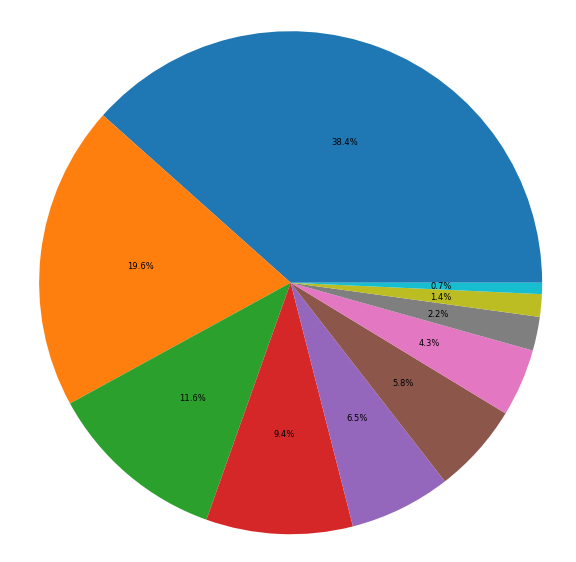

In [9]:
print(colonization_df_cleaned['Colonizer Country'].value_counts())

plt.figure(figsize=(12,12), dpi=60, facecolor='w', edgecolor='k')
plt.pie(colonization_df_cleaned['Colonizer Country'].value_counts(), autopct = '%1.1f%%')
plt.axis('equal');

In [10]:
colonization_df_cleaned.to_csv("datasets/colonies_wikipedia.csv")

In [11]:
# TO DO
# - Cleaner le dataset

In [12]:
# TEEEEEEEEEST
#URL_QS = 'https://en.wikipedia.org/wiki/Eritrea'
#r = requests.get(URL_QS)
#soup = BeautifulSoup(r.text, 'lxml')

#linkbox = soup.find(class_="catlinks")
#linkbox.find(text=re.compile('establishments'))